In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

In [ ]:
import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP # This implements the variance of the y
from botorch.utils.transforms import normalize,unnormalize

## Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
# botorch.optim.optimize.optimize_acqf_mixed
from botorch.optim import optimize_acqf_mixed

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


>## Import Data from Round1 and Round2

In [5]:
data_summary = pd.read_csv('data_out_review.csv') #pd.read_csv('data_out.csv')
data_summary.head()

,00_time,00_temp,00_sulf,00_anly,00_yieldproduct,1A_time,1A_temp,1A_sulf,1A_anly,1A_yieldproduct,1B_time,1B_temp,1B_sulf,1B_anly,1B_yieldproduct,1C_time,1C_temp,1C_sulf,1C_anly,1C_yieldproduct
0,49,45,89,84,0.009799,153,104,75,57,0.294038,68,58,85,65,0.404188,132,62,93,90,0.035990
1,49,45,89,84,0.007847,153,104,75,57,0.908395,68,58,85,65,0.218760,132,62,93,90,0.033651
2,49,45,89,84,0.012064,153,104,75,57,0.344077,68,58,85,65,0.217714,132,62,93,90,0.042650
3,87,95,95,97,0.112870,260,104,80,38,0.523446,101,133,85,98,0.566085,144,89,84,57,0.050086
4,87,95,95,97,0.100768,260,104,80,38,0.488845,101,133,85,98,0.485297,144,89,84,57,0.050017


In [ ]:
avg_data00 = data_summary.groupby('00_time').mean().reset_index()[['00_time','00_temp','00_sulf','00_anly','00_yieldproduct']].rename(columns = {'00_time':"time",'00_temp':"temp",'00_sulf':"sulf",'00_anly':"anly",'00_yieldproduct':"yield product"})
std_data00 = data_summary.groupby('00_time').std().reset_index()[['00_time','00_temp','00_sulf','00_anly','00_yieldproduct']].rename(columns = {'00_time':"time",'00_temp':"temp",'00_sulf':"sulf",'00_anly':"anly",'00_yieldproduct':"yield product"})

avg_data2B = data_summary.groupby('1B_time').mean().reset_index()[['1B_time','1B_temp','1B_sulf','1B_anly','1B_yieldproduct']].rename(columns = {'1B_time':"time",'1B_temp':"temp",'1B_sulf':"sulf",'1B_anly':"anly",'1B_yieldproduct':"yield product"})
std_data2B = data_summary.groupby('1B_time').std().reset_index()[['1B_time','1B_temp','1B_sulf','1B_anly','1B_yieldproduct']].rename(columns = {'1B_time':"time",'1B_temp':"temp",'1B_sulf':"sulf",'1B_anly':"anly",'1B_yieldproduct':"yield product"})

In [8]:
def scatter_results(data,mean,var):
    x_values = data
    y_values = mean.numpy().squeeze()
    yvar_values = var.numpy().squeeze()
    # Define the pairs of features to plot
    feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    #lev = np.linspace(0.0,1.0,100)
    # Create contour plots for each pair of features
    plt.figure(figsize=(14, 9))
    for i, (f1, f2) in enumerate(feature_pairs):
        # Extract the pair of features
        x_pair = x_values[:, [f1, f2]].numpy()
        
        # Plot the contour plot
        plt.subplot(2, 3, i + 1)
        plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values, cmap='viridis',marker = "h", alpha = 0.5, s=1100)
        #plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values+yvar_values, cmap='coolwarm',marker = "s", alpha = 0.7, s=100)
        #plt.scatter(x_pair[:,0,],x_pair[:,1] , c = y_values-yvar_values, cmap='coolwarm',marker = "s", alpha = 0.7, s=100)
        #plt.scatter(x, y, c = zvar, cmap='viridis',marker = "s",alpha = 1, s=6)
        # plt.scatter(x, y, c = z-zvar, cmap='viridis',marker = "s",alpha = 0.5, s=3)
        #plt.scatter(xt_pair[:,0],xt_pair[:,1],color = 'k',marker="*")
        #plt.scatter(x, y, c = z-zvar, cmap='viridis',alpha = 0.3)
        plt.colorbar(label='Output')
        plt.xlabel(f'Feature {f1+1}')
        plt.ylabel(f'Feature {f2+1}')
        plt.title(f'Contour Plot: Feature {f1+1} vs Feature {f2+1}')

    plt.suptitle('Contour Plots for mean')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [9]:
def contour_combination(x_train,data,mean,var,title):
    x_values = data
    y_values = mean.numpy().squeeze()
    yvar_values = var.numpy().squeeze()

    lev = 10#np.linspace(0.5,1.0,20)
    # Interpolate between points
    n = 500j
    # Define the pairs of features to plot
    feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    #lev = np.linspace(0.0,1.0,100)
    # Create contour plots for each pair of features
    plt.figure(figsize=(14, 9))
    for i, (f1, f2) in enumerate(feature_pairs):
        # Extract the pair of features
        xt_pair = x_train[:, [f1, f2]].numpy()
        x_pair = x_values[:, [f1, f2]].numpy()

        # Interpolate the data onto a regular grid
        grid_x, grid_y = np.mgrid[min(x_pair[:,0]):max(x_pair[:,0]):n, min(x_pair[:,1]):max(x_pair[:,1]):n] #np.meshgrid(x1.sort(),x2.sort())

        # Interpolate the mean and variance
        grid_mean = griddata((x_pair[:,0], x_pair[:,1]), y_values, (grid_x, grid_y), method='linear')
        grid_variance = griddata((x_pair[:,0], x_pair[:,1]), yvar_values, (grid_x, grid_y), method='linear')

        # Plot the contour plot
        plt.subplot(2, 3, i + 1)
        # Contour plot for the mean
        contour_mean = plt.contourf(grid_x, grid_y, grid_mean, levels=lev, cmap='viridis', alpha=0.8) #plt.contourf(grid_x, grid_y, grid_mean, levels=20, cmap='viridis', alpha=0.8) / plt.contour(grid_x, grid_y, grid_mean, levels=10, colors='white', linestyles='dashed')
        #plt.clabel(contour_mean, fmt='%1.2f', colors='white', fontsize=8)
        plt.colorbar(contour_mean, label='Posterior Mean')

        # Overlay contour lines for the variance
        contour_variance = plt.contour(grid_x, grid_y, grid_variance, levels= 10, colors='white', linestyles='dashed') #plt.contourf(grid_x, grid_y, grid_variance, levels=20, cmap='viridis', alpha=0.8) / plt.contour(grid_x, grid_y, grid_variance, levels=10, colors='white', linestyles='dashed')
        plt.clabel(contour_variance, fmt='%1.2f', colors='white', fontsize=8)
        #plt.colorbar(contour_variance, label='Contour_variance')
        
        plt.scatter(xt_pair[:,0],xt_pair[:,1],color = 'k',marker="*")
        plt.xlabel(f'Feature {f1+1}')
        plt.ylabel(f'Feature {f2+1}')
        plt.title(f'Contour Plot: Feature {f1+1} vs Feature {f2+1}')

    plt.suptitle(title)
    #plt.title('Contour Plot of Posterior Mean with Variance')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [10]:
def grid_split(mean,num_points,A1,B2,C3,D4,title,cmaps):
    mean = mean.reshape(num_points,num_points,num_points,num_points)
    plt.figure(figsize=(14, 11))
    plt.subplot(3,3,1)
    for i in range(num_points):
        plt.contourf(A1[:,:,i,i],B2[:,:,i,i],mean[:,:,i,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("time")
    plt.ylabel("temp")

    plt.subplot(3,3,2)
    for i in range(num_points):
        plt.contourf(A1[:,i,:,i],C3[:,i,:,i],mean[:,i,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("time")
    plt.ylabel("sulf")

    plt.subplot(3,3,3)
    for i in range(num_points):
        plt.contourf(A1[:,i,i,:],D4[:,i,i,:],mean[:,i,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("time")
    plt.ylabel("anly")

    plt.subplot(3,3,4)
    for i in range(num_points):
        plt.contourf(B2[i,:,:,i],C3[i,:,:,i],mean[i,:,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("temp")
    plt.ylabel("sulf")

    plt.subplot(3,3,5)
    for i in range(num_points):
        plt.contourf(B2[i,:,i,:],D4[i,:,i,:],mean[i,:,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("temp")
    plt.ylabel("anly")

    plt.subplot(3,3,6)
    for i in range(num_points):
        plt.contourf(C3[i,i,:,:],D4[i,i,:,:],mean[i,i,:,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.xlabel("sulf")
    plt.ylabel("anly")
    
    plt.suptitle(title)
    plt.tight_layout()

In [11]:
def gpevaluate(model,grid):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(grid)
    mean = posterior.mean
    var = posterior.variance
    return mean, var

In [12]:
def num_samples_thresh(set_list):
    thresh_samples = np.zeros(len(set_list))
    count = 0
    for i in range(len(set_list)):
        if set_list["yield product"][i].item() > 0.80:
            thresh_samples[i] = count
            count +=1
        else:
            thresh_samples[i] = count
    return thresh_samples

# Split the data

In [13]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) #torch.stack([torch.zeros(4), 100 * torch.ones(4)])

x0 = torch.tensor([avg_data00['time'].to_numpy(),avg_data00['temp'].to_numpy(),avg_data00['sulf'].to_numpy(),avg_data00['anly'].to_numpy()],dtype=torch.float32).T
x0_norm = normalize(x0,bounds)
y0 = torch.tensor(avg_data00['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
yvar0 = torch.tensor(std_data00['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)

x1 = torch.tensor([avg_data2B['time'].to_numpy(),avg_data2B['temp'].to_numpy(),avg_data2B['sulf'].to_numpy(),avg_data2B['anly'].to_numpy()],dtype=torch.float32).T
x1_norm = normalize(x1,bounds)
y1 = torch.tensor(avg_data2B['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
yvar1 = torch.tensor(std_data2B['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)


In [14]:
# Define the ranges for each variable
a_min, a_max = 30, 600 # 30 - 600
b_min, b_max = 20, 170 #30 - 150
c_min, c_max = 75, 100 # 75 - 100
d_min, d_max = 33, 100 # 33- 100

# Number of points in each dimension
num_points = 15

# Generate linspace for each variable
a = torch.linspace(a_min, a_max, num_points)
b = torch.linspace(b_min, b_max, num_points)
c = torch.linspace(c_min, c_max, num_points)
d = torch.linspace(d_min, d_max, num_points)
grid_stack = torch.stack([a,b,c,d],dim = -1)

#grid = torch.stack([a, b, c, d], dim=1)
# Create a meshgrid
A, B, C, D = torch.meshgrid(a,b,c,d, indexing='ij')

# Flatten the grid to get all combinations
grid = torch.stack([A.flatten(), B.flatten(), C.flatten(), D.flatten()], dim=-1)
grid = normalize(grid,bounds)
# Print the shape of the grid
print(grid.shape)  # Should be (num_points**4, 4)

torch.Size([50625, 4])


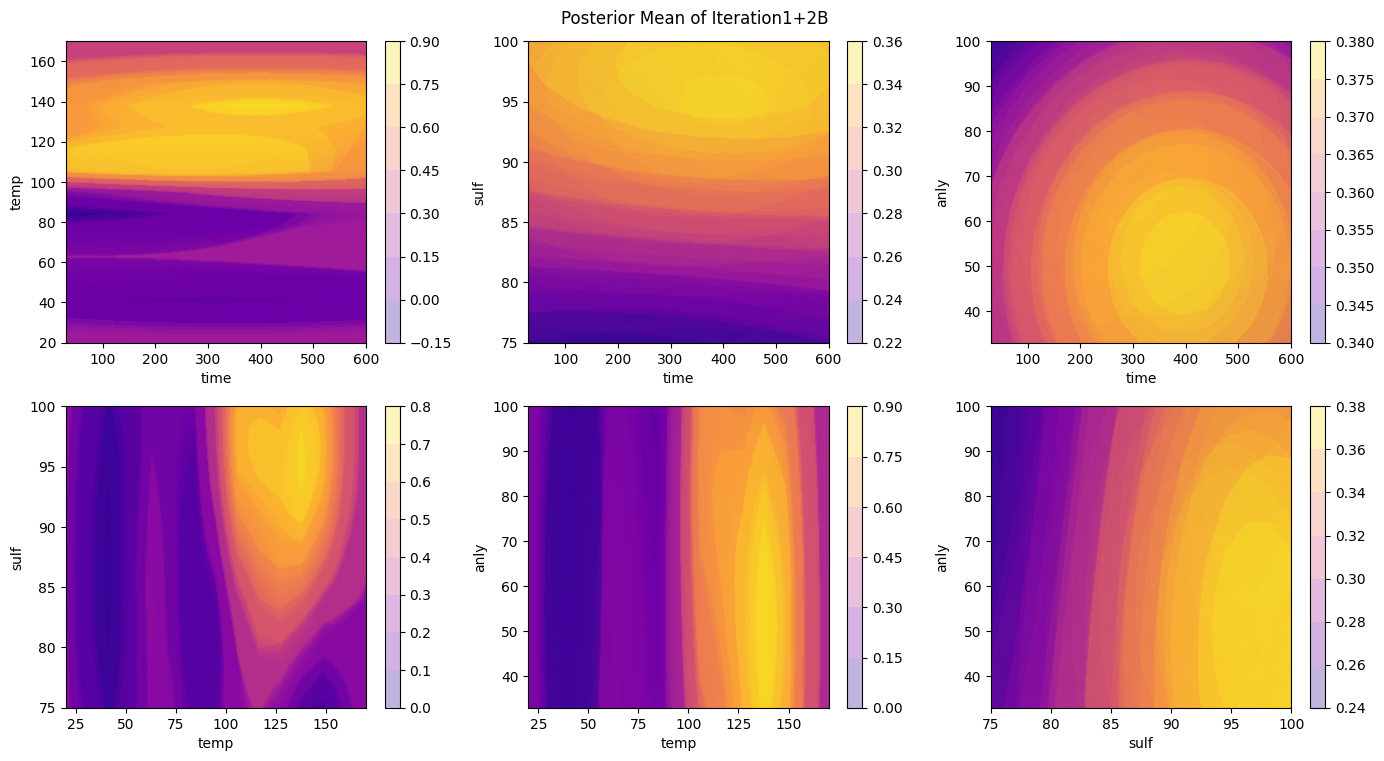

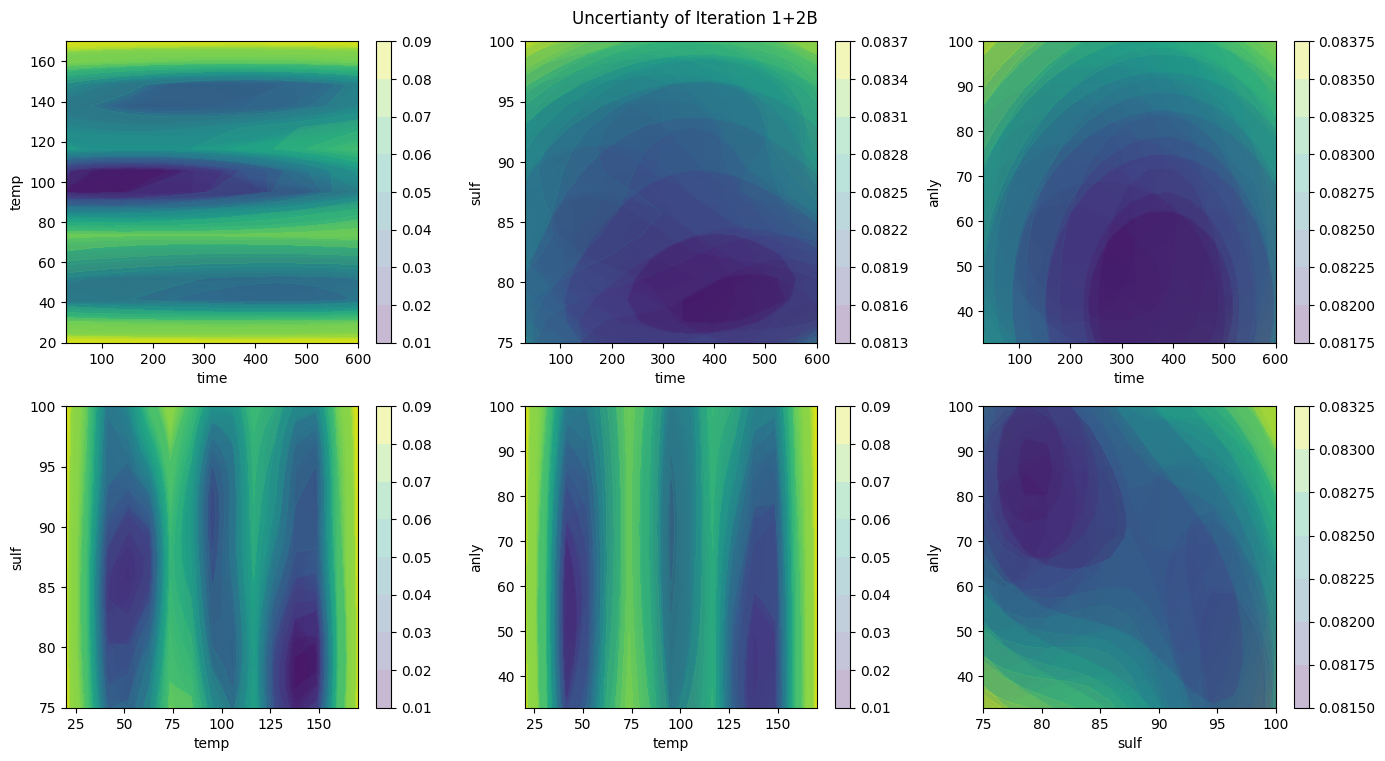

In [15]:
train_x = torch.tensor(torch.vstack([x0_norm,x1_norm]), dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(torch.vstack([y0,y1]), dtype=dtype)
train_yvar = torch.tensor(torch.vstack([yvar0,yvar1]), dtype=dtype)

## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(train_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll0 = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll0)

mean1,var1 = gpevaluate(gp_model ,grid)

grid_split(mean1,num_points,A,B,C,D,'Posterior Mean of Iteration1+2B',cmaps='plasma')
grid_split(var1,num_points,A,B,C,D,'Uncertianty of Iteration 1+2B',cmaps='viridis')

# 4D BO to determine temps

In [16]:
# #bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
# bounds = torch.tensor([[0., 0., 0. , 0.], [1., 1., 1.,1.]], dtype=dtype, device=device)
# #bounds = torch.tensor([[avg_data['time'].min(),avg_data['temp'].min(),avg_data['sulf'].min() , avg_data['analyte'].min()], [avg_data['time'].max(), avg_data['temp'].max(), avg_data['sulf'].max() , avg_data['analyte'].max()]], dtype=dtype, device=device)
# #[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]
# batch_size = 15 #train_size

# For EI 
best_f = torch.tensor(1. ,dtype=dtype) 
target_vector = torch.tensor([1.],dtype=dtype) # target is 95% or highers


In [17]:
train_x = torch.tensor(torch.vstack([x0_norm,x1_norm]), dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(torch.vstack([y0,y1]), dtype=dtype)
train_yvar = torch.tensor(torch.vstack([yvar0,yvar1]), dtype=dtype)

# Cluster

In [18]:
# USE SAME TEMPS FROM 4D Cluster run
#Centroids of Temperature Clusters:
centroids = np.array([71.,  138., 119.])


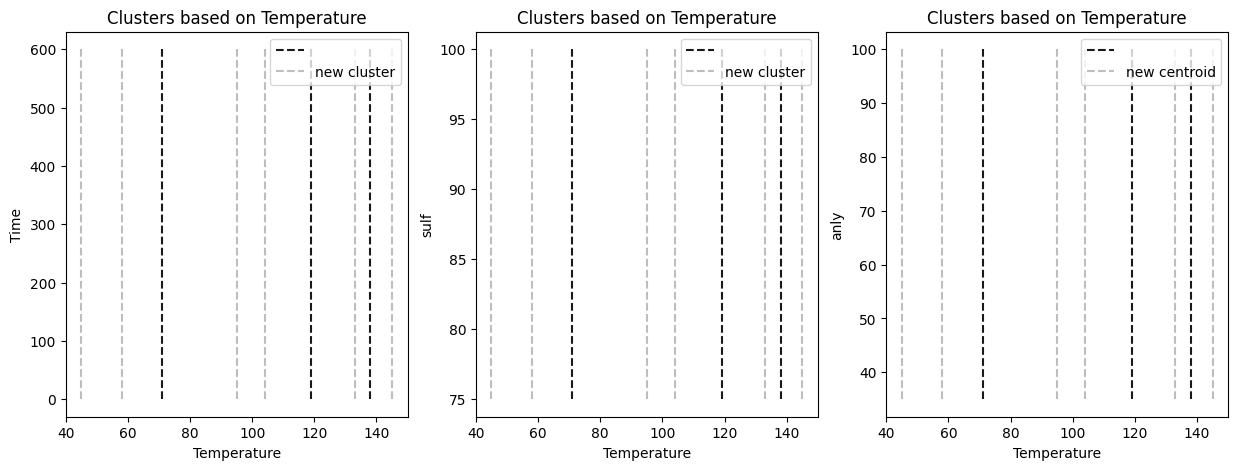

In [ ]:
old =  [45.,145.,95.,104.,58.,133.]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
#plt.scatter(df_candidate0['temp'], df_candidate0['time'], color="tab:blue")
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])

plt.subplot(1,3,2)
#plt.scatter(df_candidate0['temp'], df_candidate0['sulf'],color="tab:orange")
plt.vlines(centroids,75,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,75,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('sulf')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])


plt.subplot(1,3,3)
#plt.scatter(df_candidate0['temp'], df_candidate0['anly'], color="tab:green")
plt.vlines(centroids,35,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,35,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('anly')
plt.title('Clusters based on Temperature')
plt.legend(['','new centroid','old centroid'])

# BO 4D Mixed variable + clustered temps

In [22]:
# Number of points per dimension
num_points = 15

# Define the ranges for each variable
a_min, a_max = 30, 600 # 30 - 600
b_min, b_max = 30, 150 #30 - 150
c_min, c_max = 75, 100 # 75 - 100
d_min, d_max = 33, 100 # 33- 100

# Generate linspace for each variable
a = torch.linspace(a_min, a_max, num_points)
c = torch.linspace(c_min, c_max, num_points)
d = torch.linspace(d_min, d_max, num_points)

# Generate a list of three distinct values repeated to match 15 points
b_values = torch.tensor([72., 119.,140.]) 
b = b_values.repeat_interleave(num_points // len(b_values))
# If num_points is not a multiple of len(d_values), you'll need to pad or trim
b = torch.cat([b, b_values[:num_points % len(b_values)]]) if num_points % len(b_values) != 0 else b

# Create the meshgrid
A1, B2, C3, D4 = torch.meshgrid(a, b, c, d, indexing='ij')

# Stack and reshape to the required grid shape
grid_mix = torch.stack([A1.flatten(), B2.flatten(), C3.flatten(), D4.flatten()], dim=-1)
grid_mix = normalize(grid_mix,bounds=bounds)
print(grid_mix.shape)  # Should print torch.Size([15, 15, 15, 15, 4])


torch.Size([50625, 4])


In [23]:
# BO parameters
batch_size = 15

# Define the bounds for continuous variables
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
bound_norm = torch.tensor([
    [0.0, 0.0, 0.0, 0.0],  # Lower bounds for the 3 continuous variables
    [1.0, 1.0,1.0, 1.0]   # Upper bounds for the 3 continuous variables
])
# xlimits = np.array([[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]])

# Discrete variable choices from 1D BO
discrete_choices = normalize(centroids,[20,170]).T
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]#[{0: float(choice)} for choice in discrete_choices]


In [24]:
from botorch.models import MixedSingleTaskGP
model = MixedSingleTaskGP(train_x, train_y, cat_dims=[1],train_Yvar=train_yvar)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

mean_mix,var_mix = gpevaluate(model ,grid_mix)

In [ ]:
# Set of aquisition functions that can be used for mixed
qEI = qExpectedImprovement(model=model, best_f=best_f)
# Re-run the BO for the mixed with constrained temps
# Choose aquisition functions
acq_funcs = qEI

# Re-run the BO for the mixed with constrained temps
candidate1, _ = optimize_acqf_mixed(
    acq_function=acq_funcs,
    bounds=bound_norm,
    q=batch_size,
    fixed_features_list=fixed_features_list,
    num_restarts=10,
    raw_samples=15,
    options={"dtype": dtype, "device": device}
)

bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
candidate1_denorm = unnormalize(candidate1,bounds=bounds )

In [27]:
time = candidate1_denorm[:,0]//1
temp = candidate1_denorm[:,1]//1
sulf = candidate1_denorm[:,2]//1
anly = candidate1_denorm[:,3]//1

data = {
    'time': time,
    'temp': temp,
    'sulf': sulf,
    'anly': anly
}
df_candidate1 = pd.DataFrame(data)
newx = df_candidate1.to_numpy()
newx

array([[551.,  71., 100.,  78.],
       [384., 138., 100.,  34.],
       [408., 119.,  99.,  42.],
       [545.,  71.,  92.,  54.],
       [596., 138.,  93.,  65.],
       [509., 119.,  93.,  67.],
       [307., 119.,  98.,  94.],
       [434.,  71.,  89.,  94.],
       [ 32., 119.,  99.,  62.],
       [368., 119.,  86.,  75.],
       [132., 119.,  89.,  89.],
       [121., 119.,  99.,  40.],
       [127.,  71.,  95.,  58.],
       [439.,  71.,  76.,  49.],
       [394., 138.,  96.,  79.]], dtype=float32)

In [28]:
df_candidate1

,time,temp,sulf,anly
0,551.0,71.0,100.0,78.0
1,384.0,138.0,100.0,34.0
2,408.0,119.0,99.0,42.0
3,545.0,71.0,92.0,54.0
4,596.0,138.0,93.0,65.0
5,509.0,119.0,93.0,67.0
6,307.0,119.0,98.0,94.0
7,434.0,71.0,89.0,94.0
8,32.0,119.0,99.0,62.0
9,368.0,119.0,86.0,75.0


Text(0.5, 1.0, '4DBO - Cluster - 4DBO')

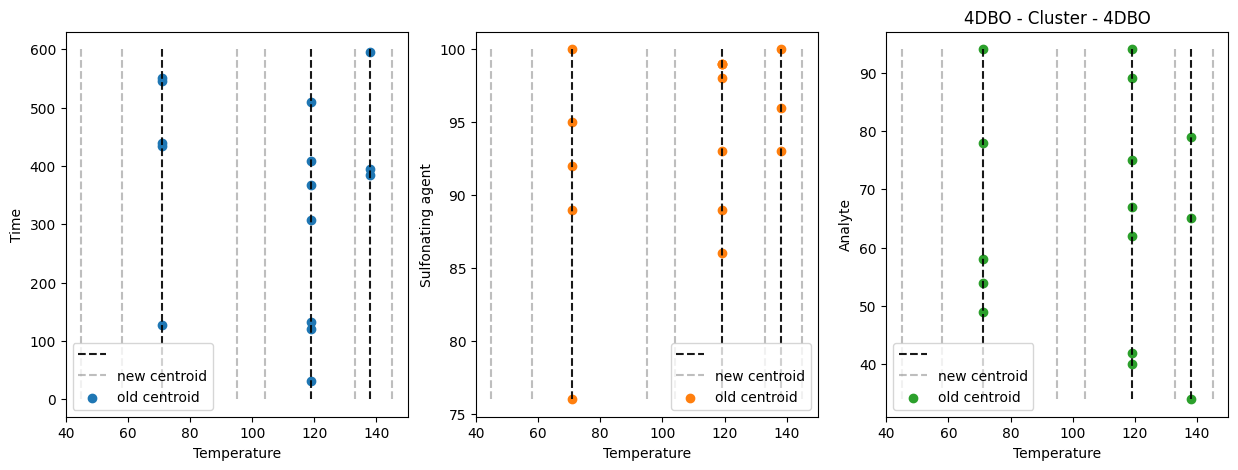

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['time'],color = 'tab:blue')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.legend(['','new centroid','old centroid'])


plt.subplot(1,3,2)
plt.vlines(centroids,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['sulf'].min(),df_candidate1['sulf'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['sulf'],color = 'tab:orange')
plt.xlabel('Temperature')
plt.ylabel('Sulfonating agent')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,3)
plt.vlines(centroids,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,df_candidate1['anly'].min(),df_candidate1['anly'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(df_candidate1['temp'],df_candidate1['anly'],color = 'tab:green')
plt.xlabel('Temperature')
plt.ylabel('Analyte')
plt.legend(['','new centroid','old centroid'])
plt.title('4DBO - Cluster - 4DBO')



In [30]:
# grid_split(mean0,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Ground Truth Model")
# grid_split(var0,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="Ground Truth Model")

In [31]:
def grid_split_new(mean,num_points,A1,B2,C3,D4,title,new_x,cmaps):
    mean = mean.reshape(num_points,num_points,num_points,num_points)
    plt.figure(figsize=(14, 11))
    plt.subplot(3,3,1)
    for i in range(num_points):
        plt.contourf(A1[:,:,i,i],B2[:,:,i,i],mean[:,:,i,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,0],new_x[:,1],marker="*",color = "k")
    plt.xlabel("time")
    plt.ylabel("temp")

    plt.subplot(3,3,2)
    for i in range(num_points):
        plt.contourf(A1[:,i,:,i],C3[:,i,:,i],mean[:,i,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,0],new_x[:,2],marker="*",color = "k")
    plt.xlabel("time")
    plt.ylabel("sulf")

    plt.subplot(3,3,3)
    for i in range(num_points):
        plt.contourf(A1[:,i,i,:],D4[:,i,i,:],mean[:,i,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,0],new_x[:,3],marker="*",color = "k")
    plt.xlabel("time")
    plt.ylabel("anly")

    plt.subplot(3,3,4)
    for i in range(num_points):
        plt.contourf(B2[i,:,:,i],C3[i,:,:,i],mean[i,:,:,i],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,1],new_x[:,2],marker="*",color = "k")
    plt.xlabel("temp")
    plt.ylabel("sulf")

    plt.subplot(3,3,5)
    for i in range(num_points):
        plt.contourf(B2[i,:,i,:],D4[i,:,i,:],mean[i,:,i,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,1],new_x[:,3],marker="*",color = "k")
    plt.xlabel("temp")
    plt.ylabel("anly")

    plt.subplot(3,3,6)
    for i in range(num_points):
        plt.contourf(C3[i,i,:,:],D4[i,i,:,:],mean[i,i,:,:],alpha = 0.3,cmap=cmaps)
    plt.colorbar()
    plt.scatter(new_x[:,2],new_x[:,3],marker="*",color = "k")
    plt.xlabel("sulf")
    plt.ylabel("anly")
    
    plt.suptitle(title)
    plt.tight_layout()

In [32]:
# grid_split_new(mean_mix,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="mixed GP",new_x=newx)
# grid_split_new(var_mix,num_points=15,A1=A1,B2=B2,C3=C3,D4=D4,title="mixed GP",new_x=newx)

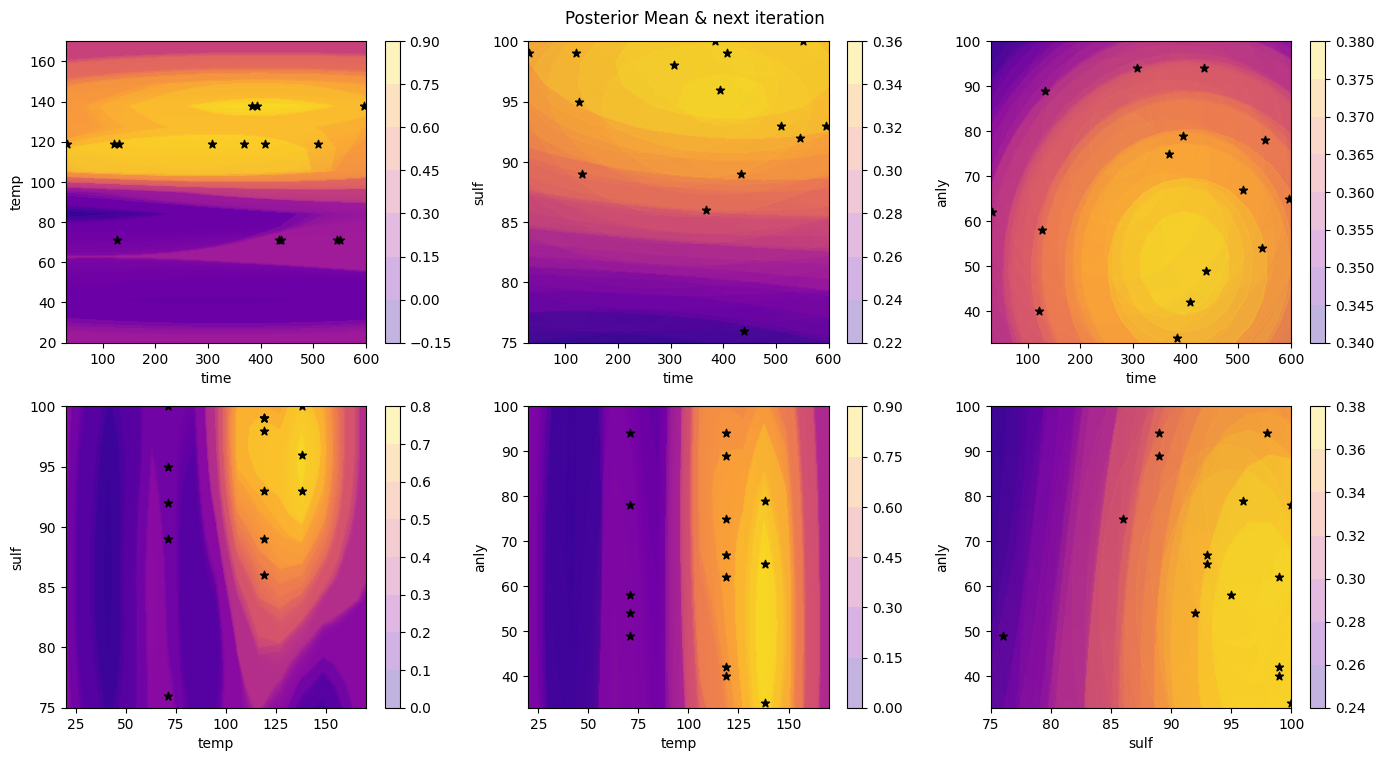

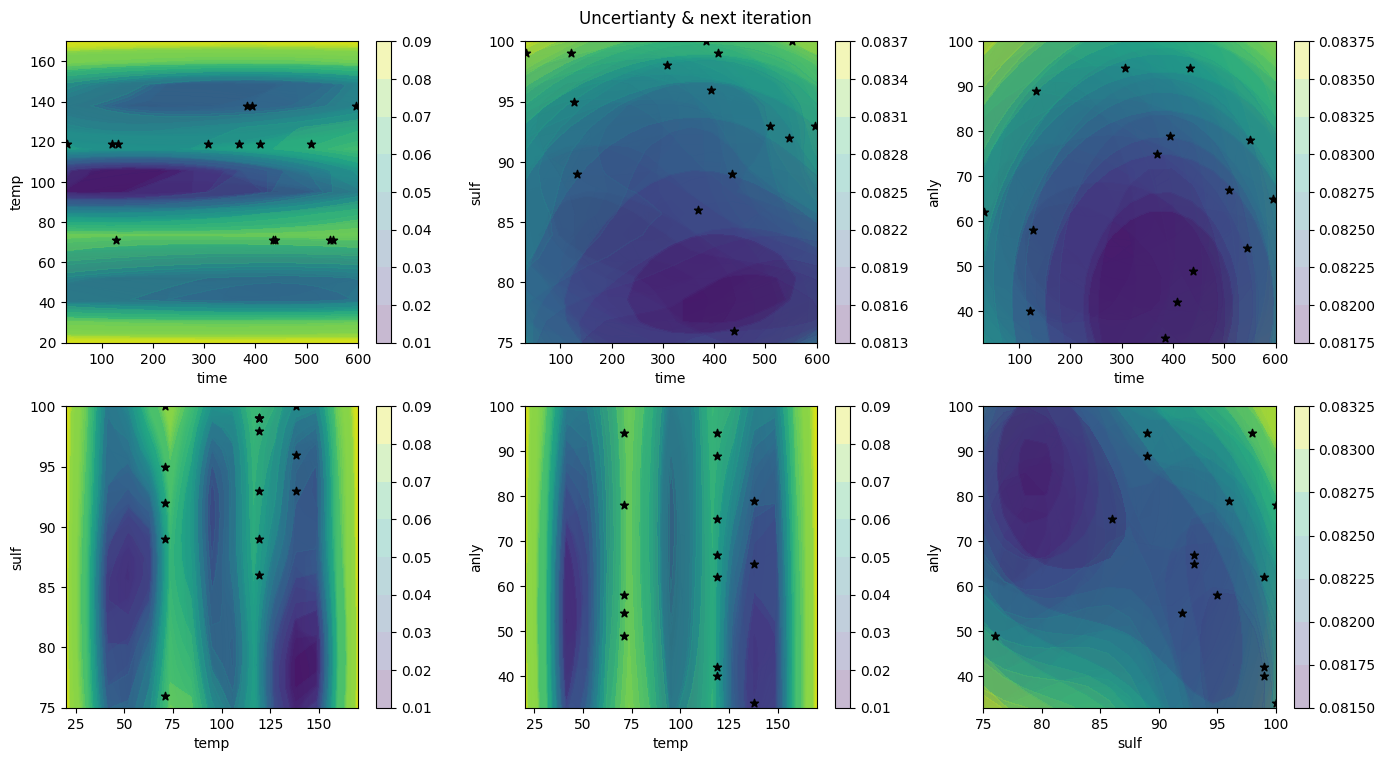

In [33]:
## Create the surrogate model
grid_split_new(mean1,num_points=15,A1=A,B2=B,C3=C,D4=D,title="Posterior Mean & next iteration",new_x=newx,cmaps="plasma")
grid_split_new(var1,num_points=15,A1=A,B2=B,C3=C,D4=D,title="Uncertianty & next iteration",new_x=newx,cmaps="viridis")